In [1]:
# Uncomment the line below to install Aer package for custom depolarizing error
# !pip install qiskit-aer

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
import numpy as np
from qiskit.circuit.library import CZGate, RXGate, RYGate, UnitaryGate, TGate, XGate, YGate, CPhaseGate, HGate
from qiskit.quantum_info import Statevector, state_fidelity, random_clifford, Clifford, DensityMatrix
import matplotlib.pyplot as plt
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import depolarizing_error, NoiseModel, thermal_relaxation_error, coherent_unitary_error, kraus_error
from scipy.linalg import sqrtm

# Gate definition

In [3]:
# Define the gates
X90, Y90 = RXGate(np.pi / 2), RYGate(np.pi / 2)
T, X, Y, H = TGate(), XGate(), YGate(), HGate()
W = UnitaryGate((X.to_matrix()+Y.to_matrix())/np.sqrt(2), label='w')
SW = UnitaryGate(sqrtm(W.to_matrix()), label='sw')
XY90 = UnitaryGate((X90.to_matrix() + Y90.to_matrix()) / np.sqrt(3), label="XY90")
XY90mm = UnitaryGate((-X90.to_matrix() - Y90.to_matrix()) / np.sqrt(3), label="XY90mm")
XY90pm = UnitaryGate((X90.to_matrix() - Y90.to_matrix()), label="XY90pm")
XY90mp = UnitaryGate((-X90.to_matrix() + Y90.to_matrix()), label="XY90mp")
# CZ, CP = CZGate(), CPhaseGate(np.pi/2)
CZ = CPhaseGate(np.pi*1)

# Possible gate sets
gate_dict1 = {0: X90, 1: Y90, 2: T}  # https://arxiv.org/abs/1608.00263
gate_dict2 = {0: X90, 1: Y90, 2: SW}  # https://www.nature.com/articles/s41586-019-1666-5
gate_dict3 = {0: X90, 1: Y90, 2: XY90, 3: XY90mm, 4: XY90pm, 5: XY90mp} # https://arxiv.org/abs/2001.08343
gate_dict4 = {0: X90, 1: Y90, 2: XY90} 
gate_sets = [gate_dict1, gate_dict2, gate_dict3, gate_dict4]
# Set for storing unique Cliffords
cliffords = []

# Generate Cliffords until we have 24 unique ones
while len(cliffords) < 24:
    # Generate a random Clifford
    c = random_clifford(1)
    # Add it to the set (this automatically checks for uniqueness)
    if c not in cliffords:
        cliffords.append(c)

# Convert set to list
cliffords = {i: c for i, c in enumerate(cliffords)}
gate_sets.append(cliffords)

# Now cliffords list contains all 24 one-qubit Clifford operators


In [4]:
# Choose the gate set
gate_set_choice = 2 # 1, 2, 3 or 4
gate_dict = gate_sets[gate_set_choice - 1]
random_gates = len(gate_dict)
print(random_gates)

3


# Noise parameters

In [5]:
num_qubits = 1  # Number of qubits
apply_CZ = True  # Apply CZ gate
error1q = 0.07
error2q = 0.03
effective_error = error2q + num_qubits*error1q if num_qubits == 2 and apply_CZ else num_qubits*error1q
depol_error1q = depolarizing_error(error1q, 1)
depol_error2q = depolarizing_error(error2q, 2)
sq_gate_set = ["h", "t", "rx", "ry", "sw"]
noise_model = NoiseModel(basis_gates = sq_gate_set)
if num_qubits == 2:
    noise_model.add_all_qubit_quantum_error(depol_error2q, ["cz"])
noise_model.add_all_qubit_quantum_error(depol_error1q, sq_gate_set)
# noise_model.add_all_qubit_quantum_error(depol_error1q, [ 'rx', 'sw', 'ry', 't'])
backend = AerSimulator(noise_model=noise_model, method="density_matrix", basis_gates=noise_model.basis_gates) 
# backend.target.add_instruction(SW, properties={(qubit,): None for qubit in range(num_qubits)}, name="sw")
print(noise_model.noise_qubits)
print(noise_model)
print(backend.operation_names)

[]
NoiseModel:
  Basis gates: ['h', 'rx', 'ry', 'sw', 't']
  Instructions with noise: ['sw', 'ry', 'h', 't', 'rx']
  All-qubits errors: ['h', 't', 'rx', 'ry', 'sw']
['continue_loop', 'kraus', 'save_probabilities_dict', 'save_expval', 'save_probabilities', 'ry', 'break_loop', 't', 'reset', 'save_amplitudes_sq', 'quantum_channel', 'if_else', 'qerror_loc', 'roerror', 'for_loop', 'rx', 'save_density_matrix', 'set_density_matrix', 'superop', 'h', 'measure', 'delay', 'while_loop', 'save_expval_var', 'save_state', 'switch_case']


/Users/arthurostrauss/anaconda3/envs/rl_qoc_v1/lib/python3.11/site-packages/qiskit/providers/backend_compat.py:127: RuntimeWarning: No gate definition for sw can be found and is being excluded from the generated target. You can use `custom_name_mapping` to provide a definition for this operation.
  warnings.warn(


# Sequence parameters

In [6]:
# np.random.seed(335)
sequences = 30 # Number of sequences
max_depth = 50# Maximum depth
step = 1 # Step for depths to be tested
n_avgs = 1000 # Number of shots
np.random.seed(13111)
dim = 2 ** num_qubits
qubits = QuantumRegister(num_qubits, "q") # Number of qubits

depths = np.arange(1, max_depth + 1, step) # Depths to be tested
sq_gates, counts_list, states_list, circuits_list, dms_list, fidelities_list, purities_list = [], [], [], [], [], [], []# 2D for 2 qubits


# Generate random sequences

In [7]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

def depolarizing_channel(qc: QuantumCircuit, qubit: int, p: float):
    """Apply depolarizing channel to a qubit in a quantum circuit.

    Args:
        qc: QuantumCircuit to apply the channel to.
        qubit: Index of the qubit the channel is applied to.
        p: Depolarizing probability.
    """
    # Randomly choose an operation
    probs = [1-p, p/3, p/3, p/3]
    op = np.random.choice(4, p=probs)

    # Apply the operation
    if op == 0:
        qc.id(qubit)
    elif op == 1:
        qc.x(qubit)
    elif op == 2:
        qc.y(qubit)
    else:
        qc.z(qubit)  # Identity operation

def bit_flip_channel(qc: QuantumCircuit, qubit: int, p: float):
    """Apply depolarizing channel to a qubit in a quantum circuit.

    Args:
        qc: QuantumCircuit to apply the channel to.
        qubit: Index of the qubit the channel is applied to.
        p: Depolarizing probability.
    """
    # Randomly choose an operation
    probs = [1-p, p]
    op = np.random.choice(2, p=probs)

    # Apply the operation
    if op == 0:
        qc.id(qubit)
    elif op == 1:
        qc.x(qubit)

def phase_flip_channel(qc: QuantumCircuit, qubit: int, p: float):
    """Apply depolarizing channel to a qubit in a quantum circuit.

    Args:
        qc: QuantumCircuit to apply the channel to.
        qubit: Index of the qubit the channel is applied to.
        p: Depolarizing probability.
    """
    # Randomly choose an operation
    probs = [1-p, p]
    op = np.random.choice(2, p=probs)

    # Apply the operation
    if op == 0:
        qc.id(qubit)
    elif op == 1:
        qc.z(qubit)

In [8]:

# Generate sequences
for s in range(sequences):  # For each sequence
    counts_list.append([])
    sq_gates.append([])
    circuits_list.append([])
    states_list.append([])
    dms_list.append([])
    fidelities_list.append([])
    purities_list.append([])
    for i, d in enumerate(depths):  # For each maximum depth
        sq_gates[s].append(np.zeros((2, d), dtype=int))
        for q in range(num_qubits):  # For each qubit
            # Generate random single qubit gates
            # Start the sequence with a random gate
            sq_gates[s][i][q][0] = np.random.randint(random_gates)
        for d_ in range(1, d):  # For each growing depth (all cycles until maximum depth d)
            for q in range(num_qubits):  # For each qubit
                sq_gates[s][i][q][d_] = np.random.randint(random_gates)
                # Make sure that the same gate is not applied twice in a row
                while sq_gates[s][i][q][d_] == sq_gates[s][i][q][d_ - 1]:
                    sq_gates[s][i][q][d_] = np.random.randint(random_gates)
        # Define the circuit
        qc = QuantumCircuit(qubits)
        # First cycle: apply Hadamard 
        for q in range(num_qubits):
            qc.append(H, [q])
        if num_qubits == 2 and apply_CZ:
            qc.append(CZ, qubits)
        for d_ in range(d):  # Apply layers
            for q in range(num_qubits):  # For each qubit, append single qubit gates
                qc.append(gate_dict[sq_gates[s][i][q][d_]], [qubits[q]])
                # depolarizing_channel(qc, q, error1q)
                # bit_flip_channel(qc, q, error1q)
                # phase_flip_channel(qc, q, error1q)
            # Apply CZ gate
            if num_qubits == 2 and apply_CZ:
                qc.append(CZ, qubits)
        # Store the statevector
        states_list[s].append(Statevector(qc)) # Ideal case
        qc.save_density_matrix()  # Actual state, subject to noise sim
        circuits_list[s].append(qc)
        

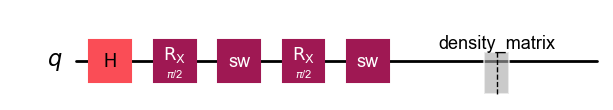

In [9]:
# Draw the circuit of your choice: first index is the sequence, second index is the depth index in depths array
circuits_list[1][3].draw(output="mpl")

# Execute the circuits

In [10]:
# Execute circuit (transpiled) and store counts
circ_list = [circuits_list[s][i].measure_all(inplace=False) for s in range(sequences) for i in range(len(depths))]
# transpiled_circs = transpile(circ_list, backend)
transpiled_circs = circ_list
job = backend.run(transpiled_circs, shots=n_avgs)
counts = job.result().get_counts()

In [11]:
dms = [job.result().data(i)["density_matrix"] for i in range(len(transpiled_circs))]
# Add missing keys to counts (Qiskit does not add all possible outcomes by default, only the ones carrying actual counts)
for count in counts:
    for key in [bin(i)[2:].zfill(num_qubits) for i in range(dim)]:
        if key not in count.keys():
            count[key] = 0
# Add counts to list
idx = 0
for s in range(sequences):
    for i in range(len(depths)): 
        counts_list[s].append(counts[idx])
        dms_list[s].append(dms[idx])
        fidelities_list[s].append(state_fidelity(dms[idx], states_list[s][i]))
        purities_list[s].append(dms[idx].purity())
        
        idx += 1


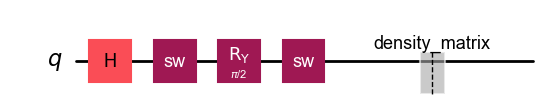

In [14]:
circuits_list[0][2].draw(output="mpl")

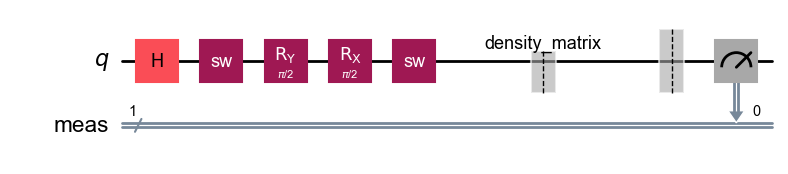

In [15]:
transpiled_circs[3].draw(output="mpl")

In [16]:
fidelities_list # State fidelity between output Density Matrix and ideal statevector

[[0.9324500000000012,
  0.9021784999999997,
  0.8740260050000024,
  0.847844184650003,
  0.8234950917245027,
  0.800850435303787,
  0.7797909048325209,
  0.7602055414942458,
  0.7419911535896484,
  0.7250517728383717,
  0.7092981487396895,
  0.6946472783279087,
  0.6810219688449562,
  0.6683504310258125,
  0.6565659008540016,
  0.6456062877942221,
  0.6354138476486308,
  0.6259348783132255,
  0.6171194368312984,
  0.6089210762531095,
  0.6012966009153913,
  0.5942058388513153,
  0.5876114301317253,
  0.581478630022502,
  0.5757751259209256,
  0.5704708671064632,
  0.5655379064090095,
  0.5609502529603808,
  0.5566837352531561,
  0.5527158737854352,
  0.5490257626204501,
  0.5455939592370245,
  0.542402382090431,
  0.5394342153441012,
  0.5366738202700155,
  0.5341066528511179,
  0.5317191871515348,
  0.5294988440509272,
  0.5274339249673636,
  0.5255135502196521,
  0.5237276017042714,
  0.522066669584979,
  0.5205220027140252,
  0.519085462524044,
  0.5177494801473644,
  0.516507016537

# Post-processing

In [17]:
def cross_entropy(p, q, epsilon=1e-15):
    """
    Calculate cross entropy between two probability distributions.

    Parameters:
    - p: numpy array, the true probability distribution
    - q: numpy array, the predicted probability distribution
    - epsilon: small value to avoid taking the logarithm of zero

    Returns:
    - Cross entropy between p and q
    """
    q = np.maximum(q, epsilon)  # Avoid taking the logarithm of zero

    # print(f"p: {p}, \nq: {q}")

    x_entropy = -np.sum(p * np.log(q))

    return x_entropy

In [18]:
from scipy.optimize import curve_fit
# Post-processing
records = []
incoherent_dist = np.ones(dim) / dim
fidelities = np.zeros((sequences, len(depths)))
expected_probs = np.zeros((sequences, len(depths), dim))
measured_probs = np.zeros((sequences, len(depths), dim))
linear_fidelities = np.zeros((sequences, len(depths)))
noise_model_fidelities = np.zeros((sequences, len(depths)))

# Reconstruct sequence from gate indices (similar step to what is done in QUA)
for s in range(sequences):
    for j, d in enumerate(depths):
        qc = QuantumCircuit(qubits)
        for q in range(num_qubits):
            qc.append(H, [q])
        if num_qubits == 2 and apply_CZ:
            qc.append(CZ, qubits)
        for k in range(d):
            sq_gates1 = [gate_dict[sq_gates[s][j][q][k]] for q in range(num_qubits)]
            # Retrieve random single qubit gates applied on both qubits
            # Apply the gates on the state
            for q, sq_gate in enumerate(sq_gates1):
                qc.append(sq_gate, [q])
            if num_qubits == 2 and apply_CZ:
                qc.append(CZ, [0, 1])
            # print("computed state: %s" % state)
        expected_probs[s, j] = Statevector(qc).probabilities()
        measured_probs[s, j] = (
            np.array([counts_list[s][j][bin(i)[2:].zfill(num_qubits)] for i in range(dim)])
            / n_avgs
        )
        xe_incoherent = cross_entropy(incoherent_dist, expected_probs[s, j])
        xe_measured = cross_entropy(measured_probs[s, j], expected_probs[s, j])
        xe_expected = cross_entropy(expected_probs[s, j], expected_probs[s, j])
        
        f_log_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
        f_linear_xeb = np.sum(measured_probs[s, j] * (dim *  expected_probs[s, j] -1))
        fidelities[s, j] = f_log_xeb
        linear_fidelities[s, j] = f_linear_xeb
        noise_model_fidelities[s, j] = (1-effective_error)**d
        
        # print(f"seq {s + 1}, depth {depths[j]}: f_xeb = {f_xeb}")
        
        records += [
            {
                "sequence": s,
                "depth": depths[j],
                "pure_probs": expected_probs[s, j],
                # "pure_probs": states_list[s][j].probabilities(),
                "sampled_probs": measured_probs[s, j],
                "circuit": circuits_list[s][j],
            }
        ]

Fxeb = np.mean(fidelities, axis=0)
Flinear = np.mean(linear_fidelities, axis=0)
Fnoise = np.mean(noise_model_fidelities, axis=0)
for record in records:
    e_u = np.sum(record["pure_probs"] ** 2)
    u_u = np.sum(record["pure_probs"]) / dim
    m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
    record.update(e_u=e_u, u_u=u_u, m_u=m_u)

/var/folders/y8/9zgwllj55dbbch4pxmg_g7jm0000gn/T/ipykernel_43948/3773590709.py:37: RuntimeWarning: invalid value encountered in scalar divide
  f_log_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
/var/folders/y8/9zgwllj55dbbch4pxmg_g7jm0000gn/T/ipykernel_43948/3773590709.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  f_log_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)


# State Heatmap

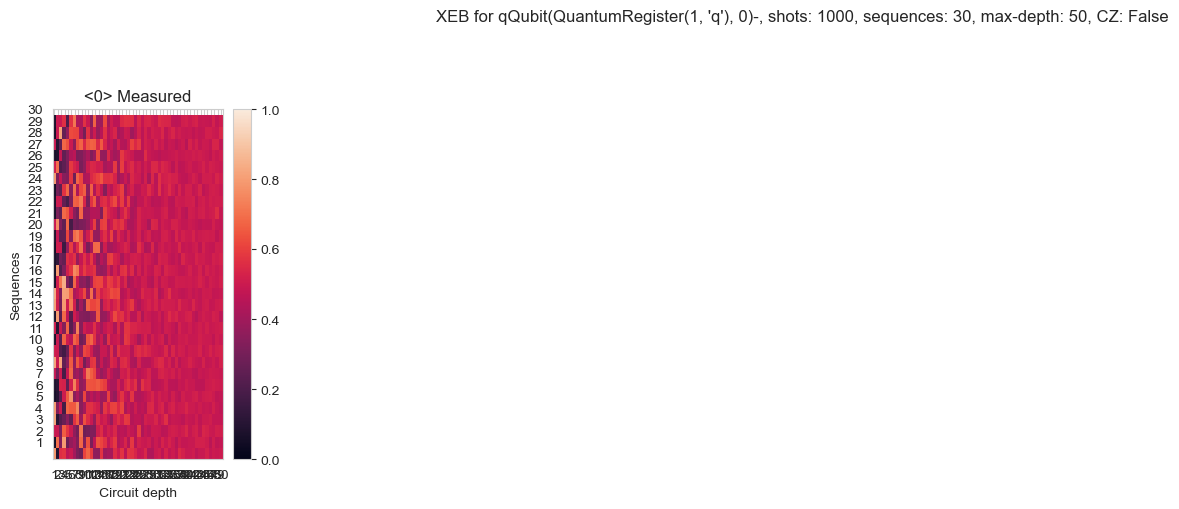

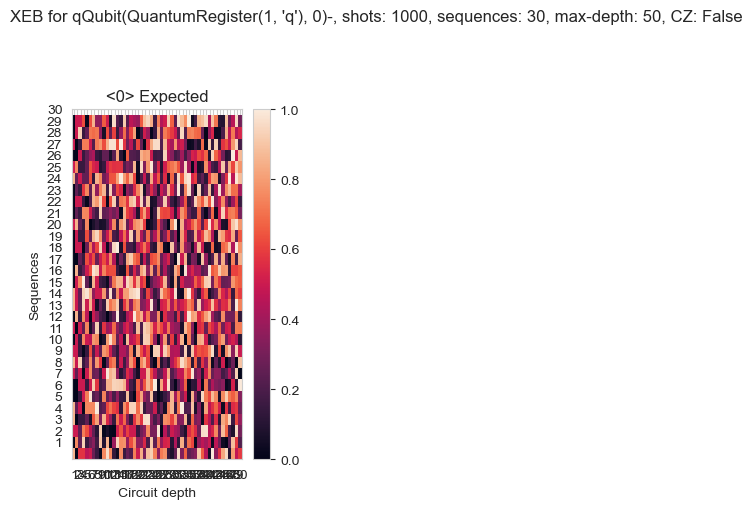

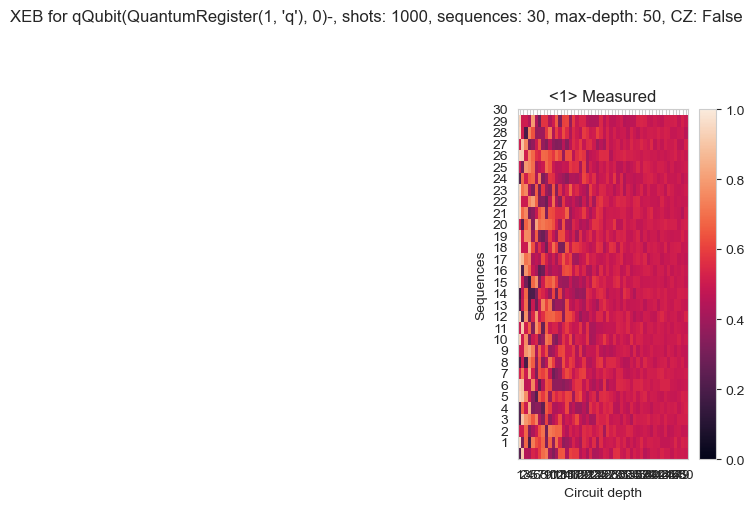

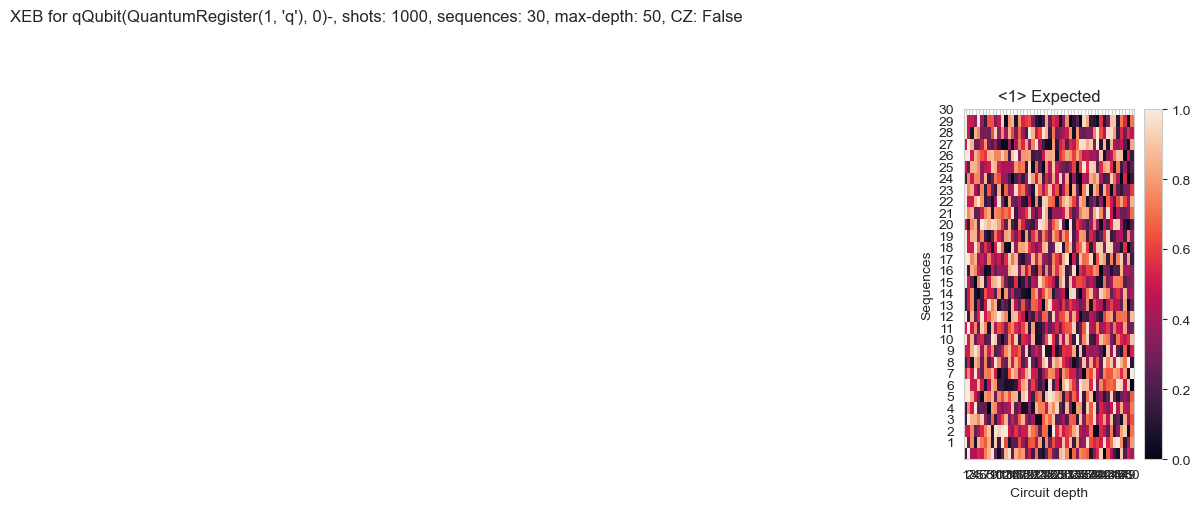

In [19]:
# Plot the results
def create_subplot(data, subplot_number, title):
    plt.subplot(subplot_number)
    plt.pcolor(depths, range(sequences), np.abs(data), vmin=0., vmax=1.0)
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("Circuit depth")
    ax.set_ylabel("Sequences")
    ax.set_xticks(depths)
    ax.set_yticks(np.arange(1, sequences + 1))
    plt.colorbar()

titles, data = [], []

for i in range(dim):
    titles.append(f"<{bin(i)[2:].zfill(num_qubits)}> Measured")
    titles.append(f"<{bin(i)[2:].zfill(num_qubits)}> Expected")
    data.append(measured_probs[:, :, i])
    data.append(expected_probs[:, :, i])

plot_number = [241, 242, 243, 244, 245, 246, 247, 248]

k = 0
for title, d, n in zip(titles, data, plot_number):
    plt.figure(figsize=(20, 10))
    qubits_involved = ""
    for q in qubits:
        qubits_involved += f"q{q}-"
    plt.suptitle(f"XEB for "+ qubits_involved+f", shots: {n_avgs}, sequences: {sequences}, max-depth: {max_depth}, CZ: {True if num_qubits == 2 else False}")
    create_subplot(d, n, title)
    plt.subplots_adjust(wspace=1.1)
    k+=1


In [20]:
import pandas as pd
df = pd.DataFrame(records)
df["y"] = df["m_u"] - df["u_u"]
df["x"] = df["e_u"] - df["u_u"]

df["numerator"] = df["x"] * df["y"]
df["denominator"] = df["x"] ** 2
df

,sequence,depth,pure_probs,sampled_probs,circuit,e_u,u_u,m_u,y,x,numerator,denominator
0,0,1,"[0.853553390593274, 0.14644660940672646]","[0.784, 0.216]","((Instruction(name='h', num_qubits=1, num_clbi...",0.750000,0.5,0.700818,0.200818,0.250000,0.050205,0.062500
1,0,2,"[9.244463733058728e-33, 0.9999999999999996]","[0.09, 0.91]","((Instruction(name='h', num_qubits=1, num_clbi...",1.000000,0.5,0.910000,0.410000,0.500000,0.205000,0.250000
2,0,3,"[0.5732233047033634, 0.4267766952966378]","[0.558, 0.442]","((Instruction(name='h', num_qubits=1, num_clbi...",0.510723,0.5,0.508494,0.008494,0.010723,0.000091,0.000115
3,0,4,"[0.5732233047033637, 0.42677669529663764]","[0.574, 0.426]","((Instruction(name='h', num_qubits=1, num_clbi...",0.510723,0.5,0.510837,0.010837,0.010723,0.000116,0.000115
4,0,5,"[0.46338834764831843, 0.5366116523516827]","[0.466, 0.534]","((Instruction(name='h', num_qubits=1, num_clbi...",0.502681,0.5,0.502490,0.002490,0.002681,0.000007,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,29,46,"[0.8880071990991287, 0.11199280090087338]","[0.488, 0.512]","((Instruction(name='h', num_qubits=1, num_clbi...",0.801099,0.5,0.490688,-0.009312,0.301099,-0.002804,0.090661
1496,29,47,"[0.2847833811347505, 0.7152166188652564]","[0.479, 0.521]","((Instruction(name='h', num_qubits=1, num_clbi...",0.592636,0.5,0.509039,0.009039,0.092636,0.000837,0.008582
1497,29,48,"[0.45547769817235384, 0.5445223018276496]","[0.526, 0.474]","((Instruction(name='h', num_qubits=1, num_clbi...",0.503964,0.5,0.497685,-0.002315,0.003964,-0.000009,0.000016
1498,29,49,"[0.9523825020452089, 0.047617497954796]","[0.476, 0.524]","((Instruction(name='h', num_qubits=1, num_clbi...",0.909300,0.5,0.478286,-0.021714,0.409300,-0.008888,0.167526


/var/folders/y8/9zgwllj55dbbch4pxmg_g7jm0000gn/T/ipykernel_43948/3230279464.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fids = df.groupby("depth").apply(per_cycle_depth).reset_index()


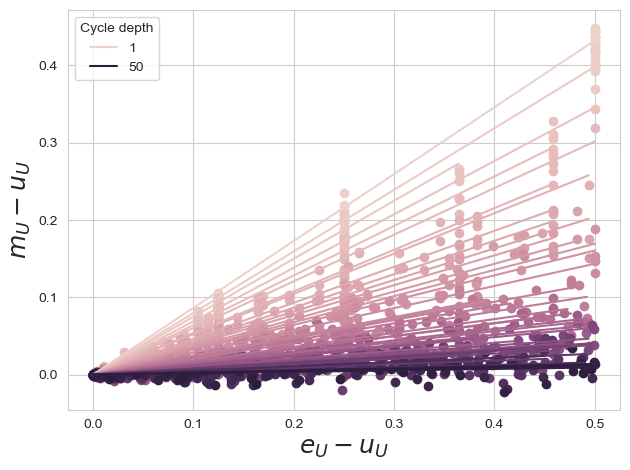

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt

# Color by cycle depth
import seaborn as sns

colors = sns.cubehelix_palette(n_colors=len(depths))
colors = {k: colors[i] for i, k in enumerate(depths)}

_lines = []


def per_cycle_depth(df):
    fid_lsq = df["numerator"].sum() / df["denominator"].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df["x"].max())
    (l,) = plt.plot(xx, fid_lsq * xx, color=colors[cycle_depth])
    plt.scatter(df["x"], df["y"], color=colors[cycle_depth])

    global _lines
    _lines += [l]  # for legend
    return pd.Series({"fidelity": fid_lsq})


fids = df.groupby("depth").apply(per_cycle_depth).reset_index()
plt.xlabel(r"$e_U - u_U$", fontsize=18)
plt.ylabel(r"$m_U - u_U$", fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0, -1]], depths[[0, -1]], loc="best", title="Cycle depth")
plt.tight_layout()

# Fidelity plot

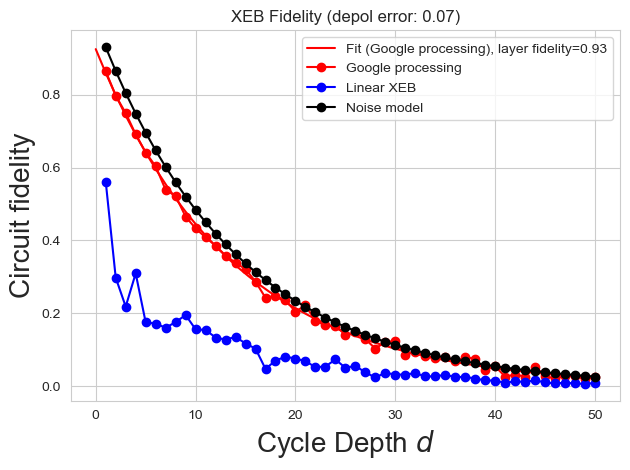

In [22]:
from typing import Tuple
from scipy import optimize
from scipy import stats


# Fit the data
def exponential_decay(cycle_depths: np.ndarray, a: float, layer_fid: float) -> np.ndarray:
    """An exponential decay for fitting.

    This computes `a * layer_fid**cycle_depths`

    Args:
        cycle_depths: The various depths at which fidelity was estimated. This is the independent
            variable in the exponential function.
        a: A scale parameter in the exponential function.
        layer_fid: The base of the exponent in the exponential function.
    """
    return a * layer_fid**cycle_depths

def _fit_exponential_decay(
    cycle_depths: np.ndarray, fidelities: np.ndarray
) -> Tuple[float, float, float, float]:
    """Fit an exponential model fidelity = a * layer_fid**x using nonlinear least squares.

    This uses `exponential_decay` as the function to fit with parameters `a` and `layer_fid`.

    Args:
        cycle_depths: The various depths at which fidelity was estimated. Each element is `x`
            in the fit expression.
        fidelities: The estimated fidelities for each cycle depth. Each element is `fidelity`
            in the fit expression.

    Returns:
        a: The first fit parameter that scales the exponential function, perhaps accounting for
            state prep and measurement (SPAM) error.
        layer_fid: The second fit parameters which serves as the base of the exponential.
        a_std: The standard deviation of the `a` parameter estimate.
        layer_fid_std: The standard deviation of the `layer_fid` parameter estimate.
    """
    cycle_depths = np.asarray(cycle_depths)
    fidelities = np.asarray(fidelities)

    # Get initial guess by linear least squares with logarithm of model.
    # This only works for positive fidelities. We use numpy fancy indexing
    # with `positives` (an ndarray of bools).
    positives = fidelities > 0
    if np.sum(positives) <= 1:
        # The sum of the boolean array is the number of `True` entries.
        # For one or fewer positive values, we cannot perform the linear fit.
        return 0, 0, np.inf, np.inf
    cycle_depths_pos = cycle_depths[positives]
    log_fidelities = np.log(fidelities[positives])

    slope, intercept, _, _, _ = stats.linregress(cycle_depths_pos, log_fidelities)
    layer_fid_0 = np.clip(np.exp(slope), 0, 1)
    a_0 = np.clip(np.exp(intercept), 0, 1)

    try:
        (a, layer_fid), pcov = optimize.curve_fit(
            exponential_decay,
            cycle_depths,
            fidelities,
            p0=(a_0, layer_fid_0),
            bounds=((0, 0), (1, 1)),
        )
    except ValueError:  # pragma: no cover
        return 0, 0, np.inf, np.inf

    a_std, layer_fid_std = np.sqrt(np.diag(pcov))
    return a, layer_fid, a_std, layer_fid_std

fit_google = True
fit_log_entropy = True
xx = np.linspace(0, fids["depth"].max())
# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    a, layer_fid, a_std, layer_fid_std = _fit_exponential_decay(fids["depth"], fids["fidelity"])
    plt.plot(xx, exponential_decay(xx, a, layer_fid),
         label='Fit (Google processing), layer fidelity={:.2f}'.format(layer_fid),
         color='red')
except:
    print("Fit for Google processing data failed")
    fit_google = False

try:
    a2, layer_fid2, a_std2, layer_fid_std2 = _fit_exponential_decay(depths[1:], Fxeb[1:])

except:
    print("Fit for Log-entropy processing data failed")
    fit_log_entropy = False
    
    
plt.plot(fids["depth"], fids["fidelity"], marker="o", color= 'red', label="Google processing")

# plt.scatter(depths, Fxeb, marker = 'o',
#             color='green', label="Log-entropy processing")
# plt.plot(xx[1:], exponential_decay(xx[1:], a2, layer_fid2),
#         label="Fit (Log-entropy processing), layer fidelity={:.2f}".format(layer_fid),
#         color="green")
plt.plot(depths, Flinear, marker="o", color="blue", label="Linear XEB")
plt.plot(depths, Fnoise, marker="o", color="black", label="Noise model")
plt.ylabel("Circuit fidelity", fontsize=20)
plt.xlabel("Cycle Depth $d$", fontsize=20)
plt.title(f"XEB Fidelity (depol error: {effective_error})")
plt.legend(loc="best")
# plt.yscale("log")
plt.tight_layout()
plt.show()

In [23]:
if fit_google:
    print("Google processing fit:")
    print("Params: ", a, layer_fid)
    print("Error per cycle: ", layer_fid)
if fit_log_entropy:
    print("Log-entropy processing fit:")
    print("Params: ", a2, layer_fid2)
    print("Error per cycle: ", layer_fid2)

Google processing fit:
Params:  0.9248137675777413 0.929424053382167
Error per cycle:  0.929424053382167
Log-entropy processing fit:
Params:  0 0
Error per cycle:  0


In [24]:
print(f"Currently used in the QM XEB example:\n {Fxeb}") # Derived from the fSim paper
print(f'Linear XEB of Google:\n {fids["fidelity"]}') # from Google's Supremacy paper

Currently used in the QM XEB example:
 [ 6.61247903e-01  4.72554945e-01  5.27448437e-01  6.64421644e-01
  5.93201443e-01  4.99794059e-01  5.34547167e-01  5.14150845e-01
  4.39692552e-01  4.38391668e-01             nan             nan
  3.78863782e-01  3.52691367e-01  1.66277182e-01  2.66855702e-01
  3.04035280e-01  2.51016651e-01  2.54077879e-01  1.93641409e-01
  1.83276433e-01  3.11865774e-01  5.98544621e-02  1.75385780e-01
  3.38457941e-01  1.51047105e-01 -9.88461257e-01  2.74891253e-01
  2.41695054e-01  7.24222604e-01 -2.92647126e-02  7.71166456e-02
 -6.64899145e-02  1.49959400e-01 -3.21164091e-03  8.63698948e-02
            -inf  8.23300408e-02  8.32144364e-02  5.39740672e-02
  5.96793791e+00 -9.84189243e-03  3.42159855e-02 -2.14554525e-02
  1.57201103e-01 -1.30164537e-01 -2.81595351e-01  2.00063594e-02
  1.23788688e-01  3.03695532e-03]
Linear XEB of Google:
 0     0.864358
1     0.796698
2     0.749435
3     0.691009
4     0.641117
5     0.603429
6     0.538574
7     0.522142
8   

In [25]:
print("absolute difference", np.abs(fids["fidelity"] - Fxeb))

absolute difference 0     0.203110
1     0.324143
2     0.221986
3     0.026587
4     0.047915
5     0.103635
6     0.004027
7     0.007991
8     0.025461
9     0.005289
10         NaN
11         NaN
12    0.020355
13    0.013952
14    0.154992
15    0.020152
16    0.061375
17    0.002739
18    0.018201
19    0.011107
20    0.038452
21    0.131947
22    0.107056
23    0.009151
24    0.197764
25    0.003098
26    1.117679
27    0.171542
28    0.120066
29    0.600382
30    0.115401
31    0.017255
32    0.148378
33    0.073079
34    0.082793
35    0.017923
36         inf
37    0.006997
38    0.037830
39    0.000382
40    5.941402
41    0.041693
42    0.007767
43    0.075485
44    0.130351
45    0.151859
46    0.308840
47    0.007842
48    0.105027
49    0.021601
Name: fidelity, dtype: float64


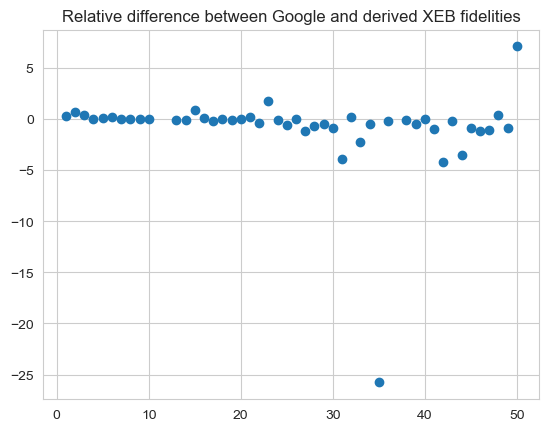

In [26]:
plt.title("Relative difference between Google and derived XEB fidelities")
plt.plot(depths, (fids["fidelity"]-Fxeb)/Fxeb, 'o', label="XEB fidelity")
